In [422]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

from matplotlib import colors

import pickle
import scipy

import seaborn as sns

from SGanalysis.SGobject import SGobject

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

In [70]:
# filepath  = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/Shared_Grant/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'
filepath = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/'

# roi_2
roi_name = 'roi_2'


# /roi_2

In [101]:
locations = pd.read_csv(f'{filepath}{roi_name}/exports/cell_attributes_cell_10px_20240605.csv',index_col=0)

# /Volumes/GRK_001/spatialbarcodes/2024-05-21_mouseexp_expression/projects/roi2/exports/

In [71]:
# matrix = pd.read_csv(f'{filepath}{roi_name}/exports/cell_by_gene_matrix_20240604.csv',index_col=0)
matrix = pd.read_csv(f'{filepath}{roi_name}/exports/cell_by_gene_matrix_20240606_10px_cell.csv',index_col=0)


In [103]:
locations

area  center_x  center_y
label                           
1      11076     23744      1159
2      11394     23809      1231
3       6409     19364      1485
4       3812     19130      1523
5      17857     19238      1574
...      ...       ...       ...
67198   5295     37975     46550
67199   8077     38213     46576
67200  10502     38383     46597
67201   7186     38110     46616
67202   5797     38505     46628

[67202 rows x 3 columns]

In [296]:
matrix.set_index(matrix.index.astype(str),inplace=True)
locations.set_index(matrix.index.astype(str),inplace=True)

In [297]:
barcode_cols = ['bc_{:03d}'.format(i) for i in range(1,97)]


Text(0, 0.5, 'number of cells with at least cutoff barcode spots')

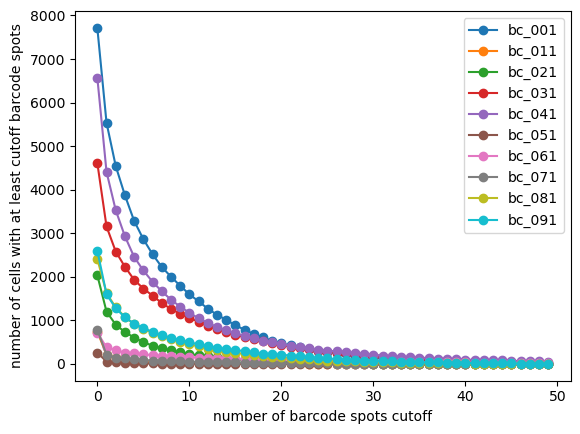

In [298]:
for bc in ['bc_{:03d}'.format(i) for i in range(1,97,10)]:

    vals = [len(matrix[matrix[bc]>c][bc].values) for c in range(50)]
    plt.plot(range(50),vals,label=bc,marker='o')
plt.legend()
plt.xlabel('number of barcode spots cutoff')
plt.ylabel('number of cells with at least cutoff barcode spots')

In [299]:
# find number of cells with at least cutoff spots per barcode

cutoff = 1
# cutoff = 3

n_cells = {}

for bc in ['bc_{:03d}'.format(i) for i in range(1,97)]:
    n_cells[bc] = len(matrix[matrix[bc]>cutoff][bc].values)




In [300]:
cell_barcodes = {}

df = matrix

# df.sort_index(inplace=True)

df['cell_id'] = df.index

for cell_id in df['cell_id']:
    this_cell = df[df['cell_id']==cell_id]
    cell_barcodes[cell_id] = []

    for bc in barcode_cols:
        if this_cell[bc].values[0] > cutoff:
            cell_barcodes[cell_id].append(bc)

df['called_barcodes'] = cell_barcodes.values()
df['n_called_barcodes'] = [len(bc_set) for bc_set in cell_barcodes.values()]
df['barcode_names'] = ['-'.join(sorted(bc_set)) for bc_set in cell_barcodes.values()]

df = pd.merge(df,locations,how='left',left_index=True,right_index=True)

In [362]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y']]

In [363]:
locations

area  center_x  center_y
1      11076     23744      1159
2      11394     23809      1231
3       6409     19364      1485
4       3812     19130      1523
5      17857     19238      1574
...      ...       ...       ...
67198   5295     37975     46550
67199   8077     38213     46576
67200  10502     38383     46597
67201   7186     38110     46616
67202   5797     38505     46628

[67202 rows x 3 columns]

<AxesSubplot: >

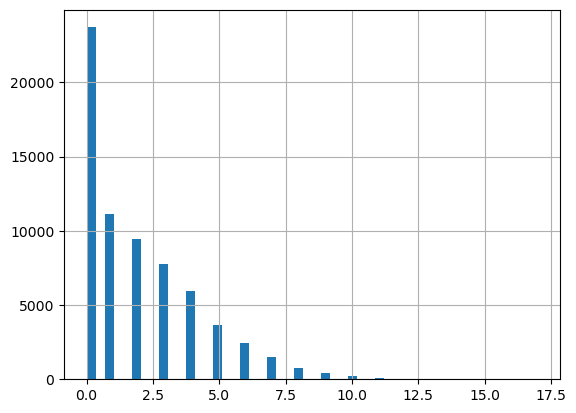

In [303]:
df['n_called_barcodes'].hist(bins=50)

In [364]:
adata_genes = sc.AnnData(df[gene_cols])

cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes','area','center_x','center_y']
# for col in :
#     adata_genes.obs[col] = df[col]

adata_genes.obs = df[cols]

/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_2639/2925818511.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes = sc.AnnData(df[gene_cols])


In [365]:
adata_genes.obs['area']

1        11076
2        11394
3         6409
4         3812
5        17857
         ...  
67198     5295
67199     8077
67200    10502
67201     7186
67202     5797
Name: area, Length: 67202, dtype: int64

In [366]:
adata_genes.var_names

Index(['SOX10', 'MLANA', 'LOXL2', 'VCAM1', 'FOSL1', 'TYR', 'MYC', 'JUN',
       'HIF1A', 'ITGAV',
       ...
       'COL1A1', 'CCND1', 'SPARC', 'FN1', 'CALD1', 'SCG2', 'BGN', 'L1CAM',
       'COL5A2', 'ENSMUSG00000071361'],
      dtype='object', length=120)

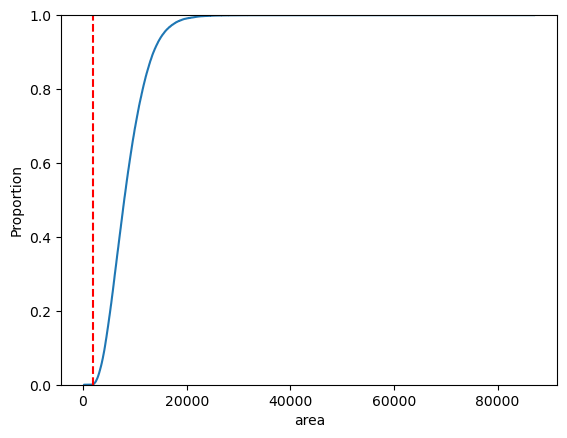

In [367]:
sns.ecdfplot(adata_genes.obs['area'],complementary=False)
plt.axvline(2000,color='red',linestyle='--')

In [368]:
min_area = 2000

adata_genes = adata_genes[adata_genes.obs['area']>min_area]

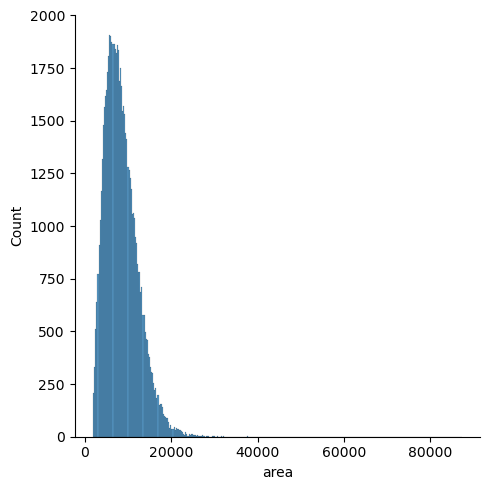

In [369]:
sns.displot(adata_genes.obs['area'])

In [374]:
sc.pp.calculate_qc_metrics(adata_genes,percent_top=None,log1p=False,inplace=True)

In [375]:
adata_genes

AnnData object with n_obs × n_vars = 67087 × 120
    obs: 'cell_id', 'n_called_barcodes', 'barcode_names', 'called_barcodes', 'area', 'center_x', 'center_y', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

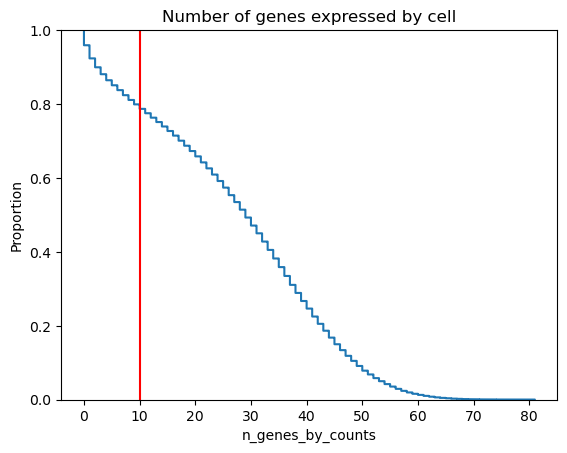

<Figure size 640x480 with 0 Axes>

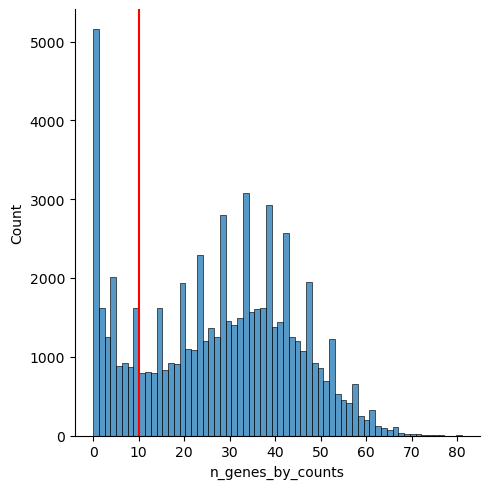

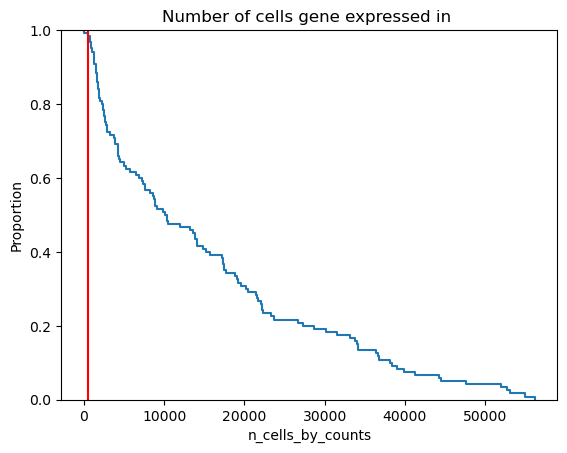

In [376]:


plt.figure()
plt.title('Number of genes expressed by cell')
sns.ecdfplot(adata_genes.obs['n_genes_by_counts'],complementary=True)
plt.axvline(10,color='r')
plt.figure()
sns.displot(adata_genes.obs['n_genes_by_counts'])
plt.axvline(10,color='r')

plt.figure()
# sns.displot(adata_genes.var['n_cells_by_counts'])
plt.title('Number of cells gene expressed in ')
sns.ecdfplot(adata_genes.var['n_cells_by_counts'],complementary=True)
plt.axvline(500,color='r')


# sns.displot()

In [377]:
# filter cells and genes by number of occurences 
sc.pp.filter_cells(adata_genes, min_genes=10) # keep only cells that have at least 10 genes
sc.pp.filter_genes(adata_genes, min_cells=500) # keep only genes that are expressed in at least 500 cells

In [378]:
sc.pp.normalize_total(adata_genes) # normalize with total number of (non-barcode) spots per cell 
sc.pp.scale(adata_genes) # scale genes across cells

# sc.pp.highly_variable_genes(adata_genes, n_top_genes=30)

## seurat v3 normalization is applied to the counts directly, 
# sc.pp.highly_variable_genes(adata_genes,n_top_genes=30,flavor='seurat_v3')
# sc.pp.highly_variable_genes(adata_genes, min_mean=0.0125, max_mean=3, min_disp=0.5,flavor='seurat_v3')
# sc.pp.pca(adata_genes)

# sc.pp.highly_variable_genes(adata_genes,n_top_genes=30,flavor='seurat_v3')

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


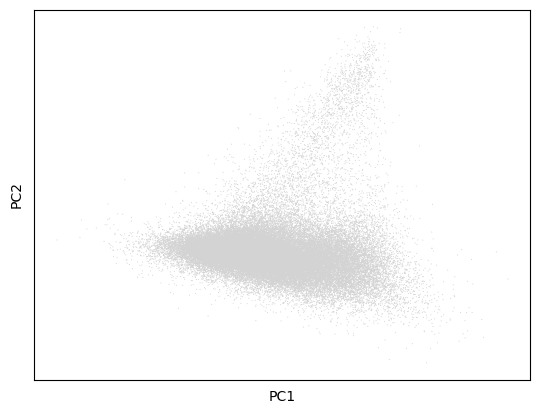

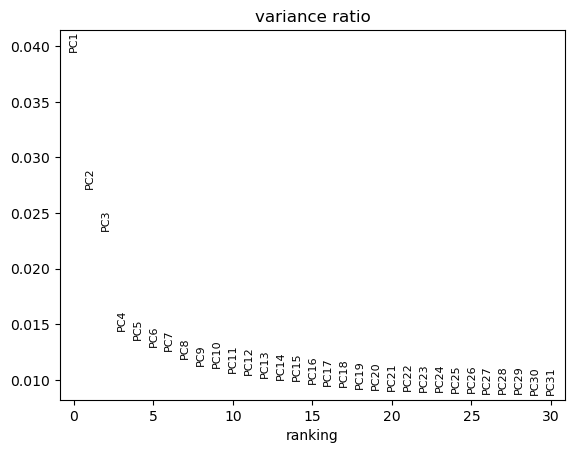

In [379]:
sc.pp.pca(adata_genes)
sc.pl.pca(adata_genes)
sc.pl.pca_variance_ratio(adata_genes, log=False)

In [380]:
sc.pp.neighbors(adata_genes)
# sc.pp.scale(adata_genes)
sc.tl.umap(adata_genes)
sc.tl.leiden(adata_genes, n_iterations=-1)

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


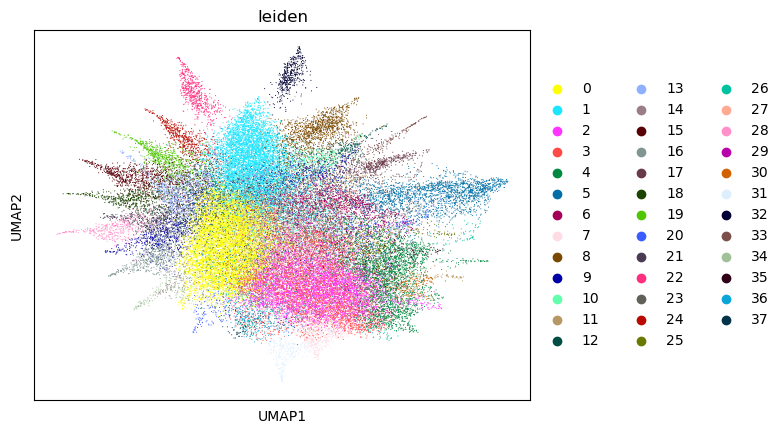

In [381]:
sc.pl.umap(adata_genes, color=["leiden"])

In [382]:
cell_cycle_genes = [x.strip() for x in open('../data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_genes.var_names]

In [383]:
sc.tl.score_genes(adata_genes,cell_cycle_genes,score_name='g2m_score')

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


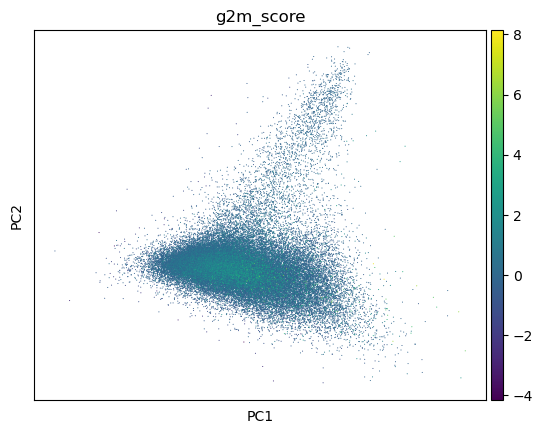

In [399]:
sc.pl.pca(adata_genes,color='g2m_score')

In [385]:
sc.pp.regress_out(adata_genes, ['g2m_score'])
sc.pp.scale(adata_genes)

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


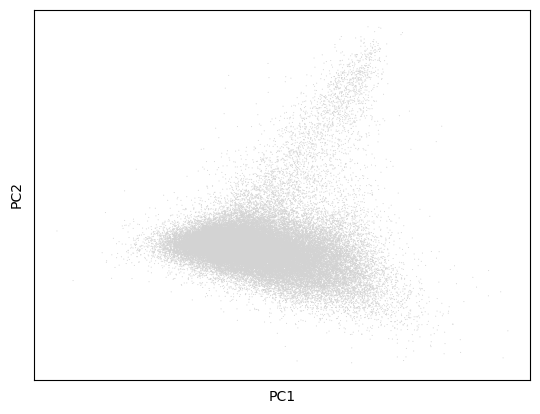

In [386]:
# I feel like this is supposed to be different after regressing out the cell cycle genes... 
sc.pp.pca(adata_genes)
sc.pl.pca(adata_genes)

In [387]:
sc.pp.neighbors(adata_genes)
# sc.pp.scale(adata_genes)
sc.tl.umap(adata_genes)
# sc.tl.leiden(adata_genes, n_iterations=-1)

In [388]:
res_list = [0.01,0.05,0.1,0.25, 0.5, 1.0]
for res in res_list:
    sc.tl.leiden(
        adata_genes, key_added=f"leiden_res_{res:4.2f}", resolution=res, random_state=42
    )


/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2

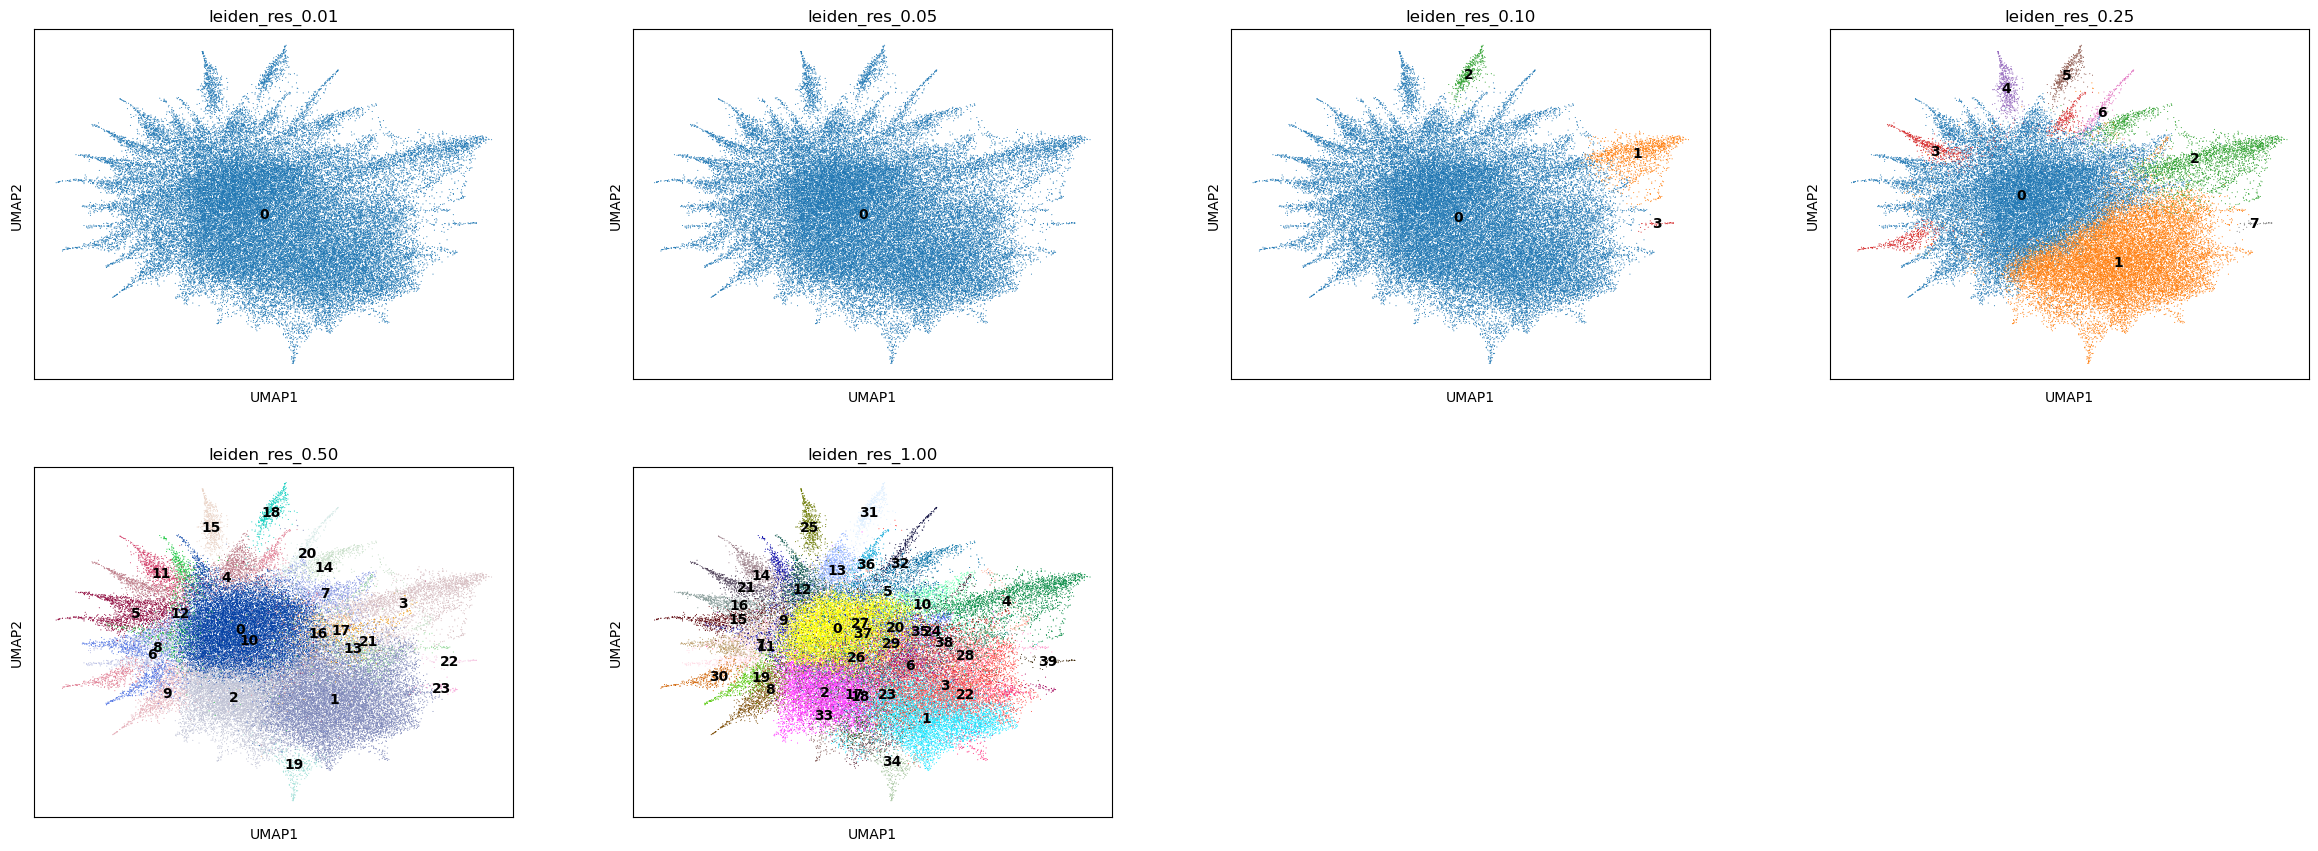

In [389]:
sc.pl.umap(
    adata_genes,
    color=[f"leiden_res_{res:4.2f}" for res in res_list],
    legend_loc="on data",
)

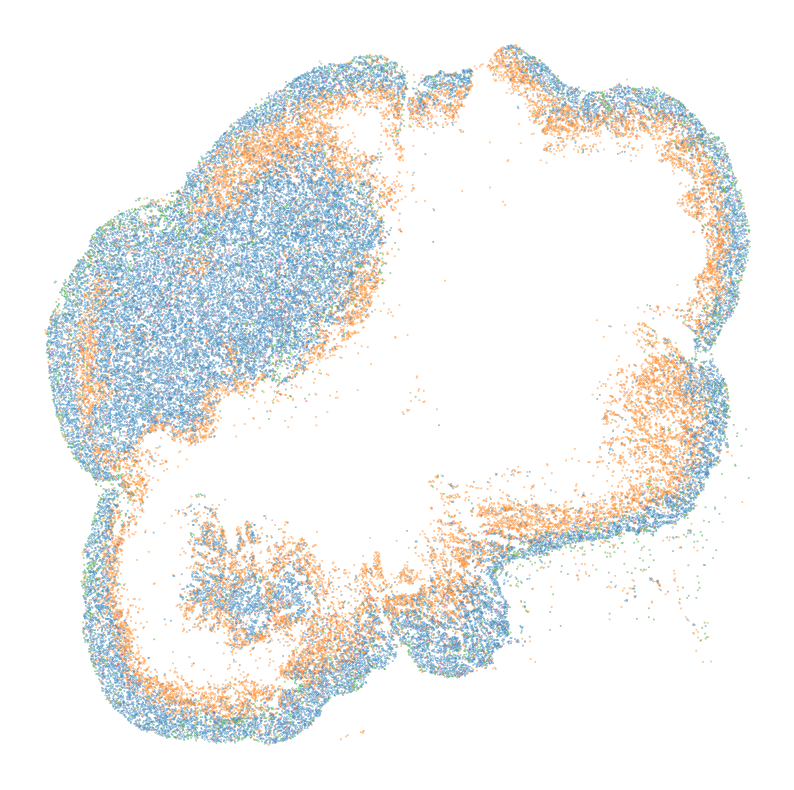

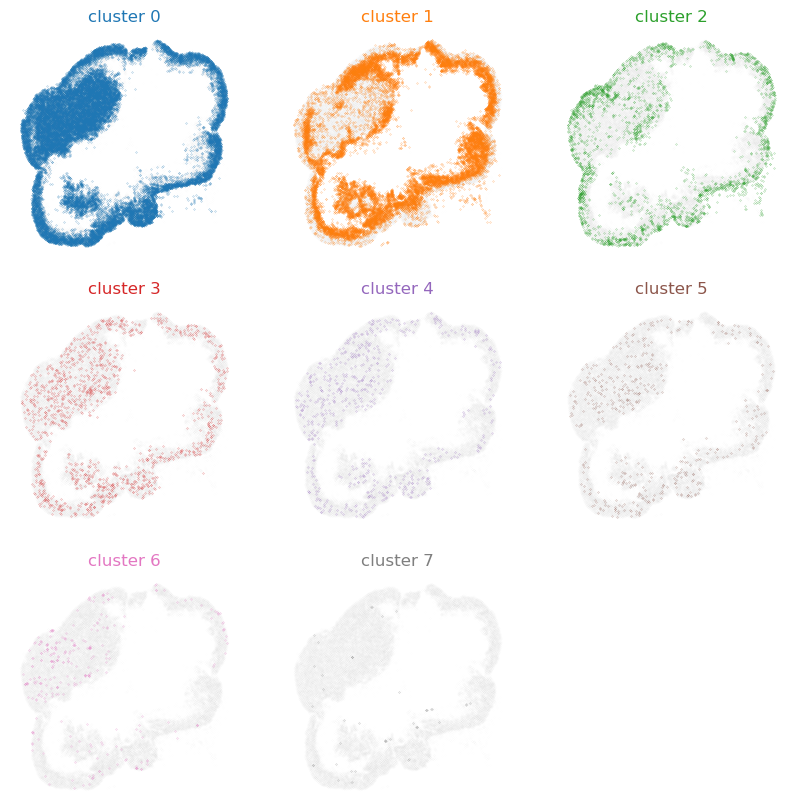

In [524]:
res_to_use = 0.25

c_dict = {str(x):c for x,c in enumerate(adata_genes.uns[f'leiden_res_{res_to_use:4.2f}_colors'])}
c_list =[c_dict[x] for x in adata_genes.obs[f'leiden_res_{res_to_use:4.2f}']]

fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='.',
            c=c_list,
            s=0.2)
plt.axis('off')

plt.figure(figsize=(10,10))
for cluster in np.unique(adata_genes.obs[f'leiden_res_{res_to_use:4.2f}']):
    plt.subplot(3,3,int(cluster)+1)
    plt.title(f'cluster {cluster}',color=c_dict[str(cluster)])
    not_cluster = adata_genes[adata_genes.obs[f'leiden_res_{res_to_use:4.2f}']!=str(cluster)]
    plt.scatter(not_cluster.obs['center_x'],not_cluster .obs['center_y'],marker='.',
                c='gray',
                s=0.1,alpha=0.01)
    
    this_cluster = adata_genes[adata_genes.obs[f'leiden_res_{res_to_use:4.2f}']==str(cluster)]
    plt.scatter(this_cluster.obs['center_x'],this_cluster.obs['center_y'],marker='.',
                c=c_dict[str(cluster)],
                s=0.1)
    plt.axis('off')
    

/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages

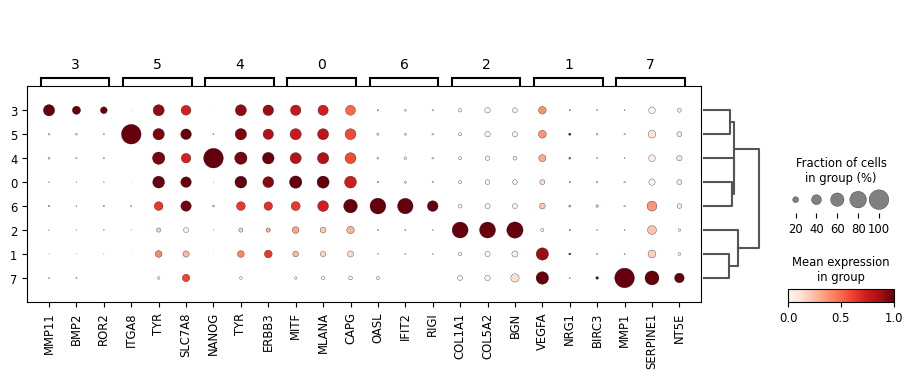

In [526]:
sc.tl.rank_genes_groups(adata_genes, groupby=f"leiden_res_{res_to_use:4.2f}", method="wilcoxon")

sc.pl.rank_genes_groups_dotplot(
    adata_genes, groupby=f"leiden_res_{res_to_use:4.2f}", standard_scale="var", n_genes=3
)

In [496]:
adata_genes[adata_genes.obs[f'leiden_res_{res_to_use:4.2f}']=='6'].obs['barcode_names']

119                   
562             bc_020
701      bc_068-bc_086
812             bc_013
1503            bc_078
             ...      
66789                 
66798                 
66801                 
67175                 
67193                 
Name: barcode_names, Length: 292, dtype: category
Categories (169, object): ['', 'bc_001', 'bc_001-bc_003-bc_014-bc_033-bc_076-bc_094', 'bc_001-bc_003-bc_014-bc_043-bc_057-bc_060-bc_..., ..., 'bc_087', 'bc_089-bc_091', 'bc_094', 'bc_095']

In [461]:
min_number_barcodes = 1

name,count = np.unique(adata_genes.obs[adata_genes.obs['n_called_barcodes']>=min_number_barcodes]['barcode_names'].values,return_counts=True)

common_bc_combos = {}

min_number_cells = 10

for n,c in zip(name,count):
    if c > min_number_cells:
        # print(n,c)
        common_bc_combos[n] = c
    # print(n,c)  


(-652.3000000000002, 59304.3, -772.1500000000001, 48885.15)

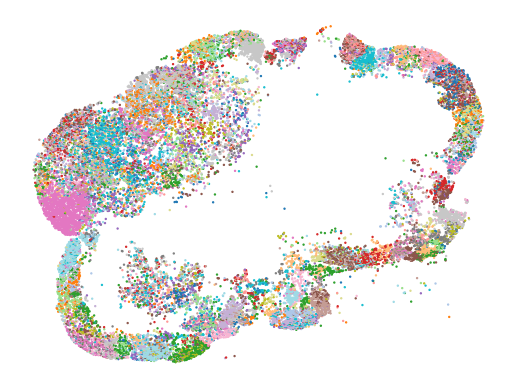

In [527]:
bc_colors = sns.color_palette('tab20',n_colors=len(common_bc_combos))
bc_color_dict = {bc:bc_colors[i] for i,bc in enumerate(common_bc_combos.keys())}

bc_color_list = [colors.to_rgba(bc_color_dict[bc],alpha=1.0) if bc in bc_color_dict.keys() else colors.to_rgba('gray',alpha=0.0)  for bc in adata_genes.obs['barcode_names'] ]

plt.scatter(adata_genes.obs['center_x'],adata_genes.obs['center_y'],marker='o',
            c=bc_color_list,
            s=0.5)

plt.axis('off')

There are some pockets of cells that appear to have mixed barcode identities - are these real or just doubleets?

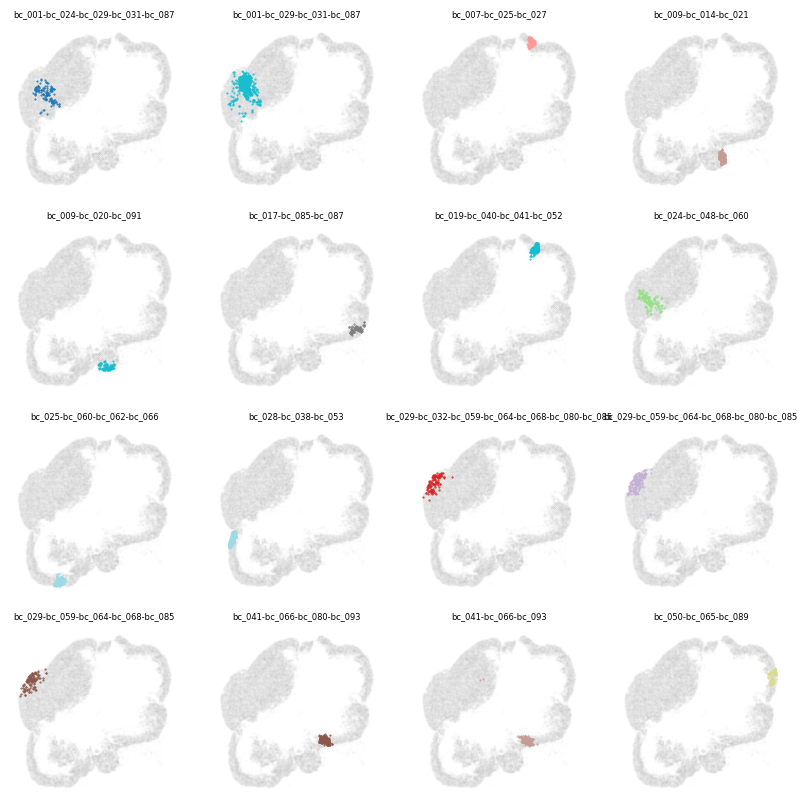

In [487]:
very_common_bcs = ['bc_001-bc_024-bc_029-bc_031-bc_087',
 'bc_001-bc_029-bc_031-bc_087',
 'bc_007-bc_025-bc_027',
 'bc_009-bc_014-bc_021',
 'bc_009-bc_020-bc_091',
 'bc_017-bc_085-bc_087',
 'bc_019-bc_040-bc_041-bc_052',
 'bc_024-bc_048-bc_060',
 'bc_025-bc_060-bc_062-bc_066',
 'bc_028-bc_038-bc_053',
 'bc_029-bc_032-bc_059-bc_064-bc_068-bc_080-bc_085',
 'bc_029-bc_059-bc_064-bc_068-bc_080-bc_085',
 'bc_029-bc_059-bc_064-bc_068-bc_085',
 'bc_041-bc_066-bc_080-bc_093',
 'bc_041-bc_066-bc_093',
 'bc_050-bc_065-bc_089']

plt.figure(figsize=(10,10))
for i,bc_name in enumerate(very_common_bcs):
    
    plt.subplot(4,4,i+1)
    plt.title(bc_name,fontsize=6)

    others = adata_genes[adata_genes.obs['barcode_names']!=bc_name]
    plt.scatter(others.obs['center_x'],others.obs['center_y'],marker='o',
            color='gray',alpha=0.01,
            s=0.1)

    this_bc = adata_genes[adata_genes.obs['barcode_names']==bc_name]

    plt.scatter(this_bc.obs['center_x'],this_bc.obs['center_y'],marker='o',
            color=bc_color_dict[bc_name],alpha=1.0,
            s=0.25)
    
    plt.axis('off')
    

In [485]:
# Let's unpack the bc041-bc066-bc093 barcode combo which is next to a bunch of bc041-bc066-bc080-bc093 cells and see what's going on there


df[df['barcode_names'].isin(['bc_041-bc_066-bc_093','bc_041-bc_066-bc_080-bc_093'])][['barcode_names','bc_041','bc_066','bc_080','bc_093']]

barcode_names  bc_041  bc_066  bc_080  bc_093
17632         bc_041-bc_066-bc_093       7       6       1       8
17714  bc_041-bc_066-bc_080-bc_093      14      10       4      17
17741  bc_041-bc_066-bc_080-bc_093      18       5       3      16
17749  bc_041-bc_066-bc_080-bc_093       4       4       2      12
17779         bc_041-bc_066-bc_093       6      10       1       6
...                            ...     ...     ...     ...     ...
22862  bc_041-bc_066-bc_080-bc_093       8       3       2       8
22982  bc_041-bc_066-bc_080-bc_093       9       4       2       5
23122  bc_041-bc_066-bc_080-bc_093       3       6       9       4
47950         bc_041-bc_066-bc_093       4       5       0       9
48502         bc_041-bc_066-bc_093      22      28       0       7

[321 rows x 5 columns]

In [488]:
bc_list = ['bc_041','bc_066','bc_080','bc_093']

import itertools.combinations as comb

for c in comb(bc_list,3):
    print(c)



ModuleNotFoundError: No module named 'itertools.combinations'; 'itertools' is not a package

In [ ]:
## Do cells with the same barcode tend to belong to one cluster or the other?"

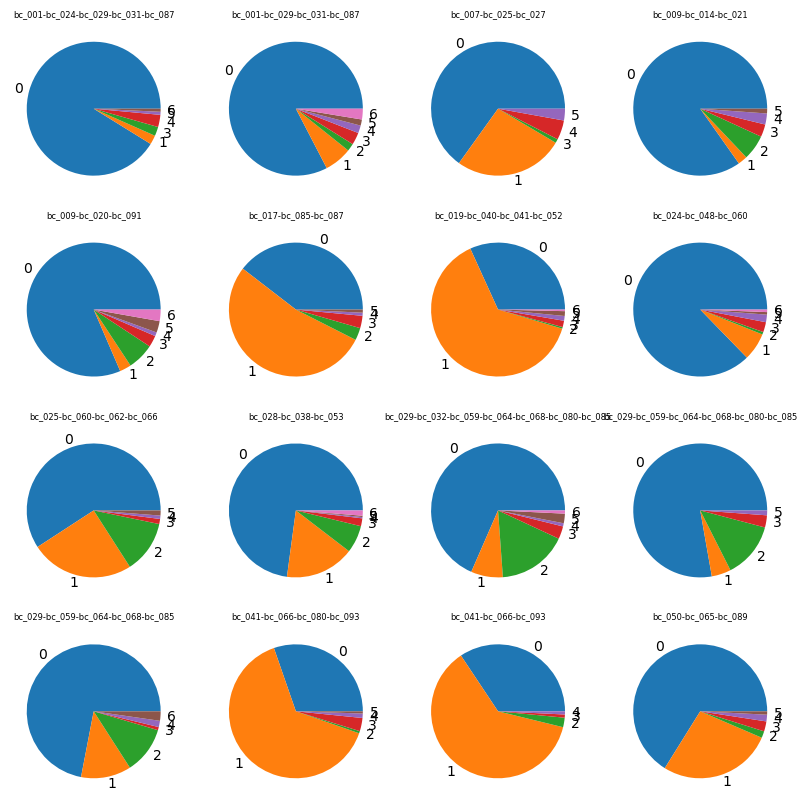

In [504]:

plt.figure(figsize=(10,10))
for i,bc_name in enumerate(very_common_bcs):
    
    plt.subplot(4,4,i+1)
    plt.title(bc_name,fontsize=6)

    # others = adata_genes[adata_genes.obs['barcode_names']!=bc_name]
    # plt.scatter(others.obs['center_x'],others.obs['center_y'],marker='o',
    #         color='gray',alpha=0.01,
    #         s=0.1)

    this_bc = adata_genes[adata_genes.obs['barcode_names']==bc_name]

    clusters,sizes = np.unique(this_bc.obs[f'leiden_res_{res_to_use:4.2f}'],return_counts=True)

    plt.pie(sizes,labels=clusters)

    
    # plt.subplot(4,4,i+1)
    # plt.title(bc_name,fontsize=6)

    # others = adata_genes[adata_genes.obs['barcode_names']!=bc_name]
    # plt.scatter(others.obs['center_x'],others.obs['center_y'],marker='o',
    #         color='gray',alpha=0.01,
    #         s=0.1)

    

    # plt.scatter(this_bc.obs['center_x'],this_bc.obs['center_y'],marker='o',
    #         color=bc_color_dict[bc_name],alpha=1.0,
    #         s=0.25)
    
    # plt.axis('off')

In [516]:
bcs,counts= np.unique(adata_genes[adata_genes.obs['leiden_res_0.25']=='6'].obs['barcode_names'],return_counts=True)
[(b,c) for b,c in zip(bcs,counts) if (c>3 and b != '')]
          

[('bc_001-bc_029-bc_031-bc_087', 14),
 ('bc_001-bc_031-bc_087', 4),
 ('bc_002', 5),
 ('bc_009-bc_091', 4),
 ('bc_022', 15),
 ('bc_025-bc_079-bc_083', 5),
 ('bc_028-bc_038-bc_053', 4),
 ('bc_050', 4)]

In [519]:
bcs,counts= np.unique(adata_genes[adata_genes.obs['leiden_res_0.25']=='5'].obs['barcode_names'],return_counts=True)
[(b,c) for b,c in zip(bcs,counts) if (c>3 and b != '')]

[('bc_001-bc_029-bc_031-bc_087', 8),
 ('bc_020', 4),
 ('bc_022', 4),
 ('bc_048-bc_060', 4),
 ('bc_050', 9),
 ('bc_060', 4)]

In [515]:
bcs,counts= np.unique(adata_genes[adata_genes.obs['leiden_res_0.25']=='3'].obs['barcode_names'],return_counts=True)
[(b,c) for b,c in zip(bcs,counts) if (c>3 and b != '')]

[('bc_001', 7),
 ('bc_001-bc_029-bc_031-bc_087', 16),
 ('bc_002', 6),
 ('bc_002-bc_094', 5),
 ('bc_004-bc_050', 4),
 ('bc_006-bc_019-bc_064-bc_094', 4),
 ('bc_007-bc_013-bc_054-bc_060', 4),
 ('bc_009', 6),
 ('bc_009-bc_014-bc_021', 8),
 ('bc_009-bc_091', 7),
 ('bc_010-bc_060-bc_081', 4),
 ('bc_013-bc_060', 4),
 ('bc_017-bc_085-bc_087', 4),
 ('bc_019-bc_040-bc_041-bc_052', 4),
 ('bc_020', 11),
 ('bc_022', 26),
 ('bc_022-bc_033', 4),
 ('bc_024', 9),
 ('bc_024-bc_048-bc_060', 4),
 ('bc_025', 5),
 ('bc_028-bc_038-bc_053', 6),
 ('bc_029-bc_032-bc_059-bc_064-bc_068-bc_080-bc_085', 4),
 ('bc_029-bc_059-bc_064-bc_068-bc_080-bc_085', 5),
 ('bc_030-bc_040-bc_058-bc_059-bc_083-bc_095', 7),
 ('bc_033', 5),
 ('bc_033-bc_095', 7),
 ('bc_041-bc_045-bc_047-bc_052', 4),
 ('bc_041-bc_066-bc_080-bc_093', 6),
 ('bc_045', 7),
 ('bc_048-bc_060', 9),
 ('bc_050', 19),
 ('bc_052-bc_068', 4),
 ('bc_058-bc_083', 9),
 ('bc_060', 6),
 ('bc_060-bc_081', 12),
 ('bc_063', 6),
 ('bc_073', 5),
 ('bc_074', 6),
 ('bc_074